In [2]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import yfinance as yf
import torch
import warnings
import sklearn

warnings.filterwarnings('ignore')

# Print versions
print("Library versions:")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"Statsmodels: {sm.__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"YFinance: {yf.__version__}")
print("\nAll libraries imported successfully! ✅")


Library versions:
NumPy: 2.3.2
Pandas: 2.3.2
Matplotlib: 3.10.6
Scikit-learn: 1.7.1
Statsmodels: 0.14.5
PyTorch: 2.8.0
YFinance: 0.2.65

All libraries imported successfully! ✅


In [10]:
# Download stock data using yfinance
ticker = "AAPL"
data = yf.download(ticker, start="2020-01-01", end="2023-12-31", progress=False)

print(f"Downloaded {len(data)} days of data for {ticker}")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
print("\nFirst 5 rows:")
print(data.head())


Downloaded 1006 days of data for AAPL
Date range: 2020-01-02 to 2023-12-29

First 5 rows:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.538506  72.598884  71.292296  71.545882  135480400
2020-01-03  71.833282  72.594048  71.608677  71.765659  146322800
2020-01-06  72.405678  72.444321  70.703012  70.954188  118387200
2020-01-07  72.065147  72.671341  71.845369  72.415337  108872000
2020-01-08  73.224411  73.526303  71.768086  71.768086  132079200


In [11]:
# Basic data analysis
print("Data Summary:")
print(data.describe())

# Calculate daily returns
data['Daily_Return'] = data['Close'].pct_change()
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))

print(f"\nDaily Return Statistics:")
print(f"Mean: {data['Daily_Return'].mean():.4f}")
print(f"Std: {data['Daily_Return'].std():.4f}")
print(f"Min: {data['Daily_Return'].min():.4f}")
print(f"Max: {data['Daily_Return'].max():.4f}")


Data Summary:
Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   1006.000000  1006.000000  1006.000000  1006.000000  1.006000e+03
mean     138.220942   139.704822   136.588526   138.090654  9.895373e+07
std       33.421410    33.541732    33.282002    33.415134  5.439610e+07
min       54.316929    55.316747    51.469994    55.215071  2.404830e+07
25%      120.626507   121.869867   119.090686   120.732239  6.407675e+07
50%      143.088577   144.665477   141.423882   142.938044  8.467540e+07
75%      163.506092   165.786473   162.250093   163.774400  1.155069e+08
max      196.446793   197.944110   195.346124   196.357552  4.265100e+08

Daily Return Statistics:
Mean: 0.0012
Std: 0.0211
Min: -0.1286
Max: 0.1198


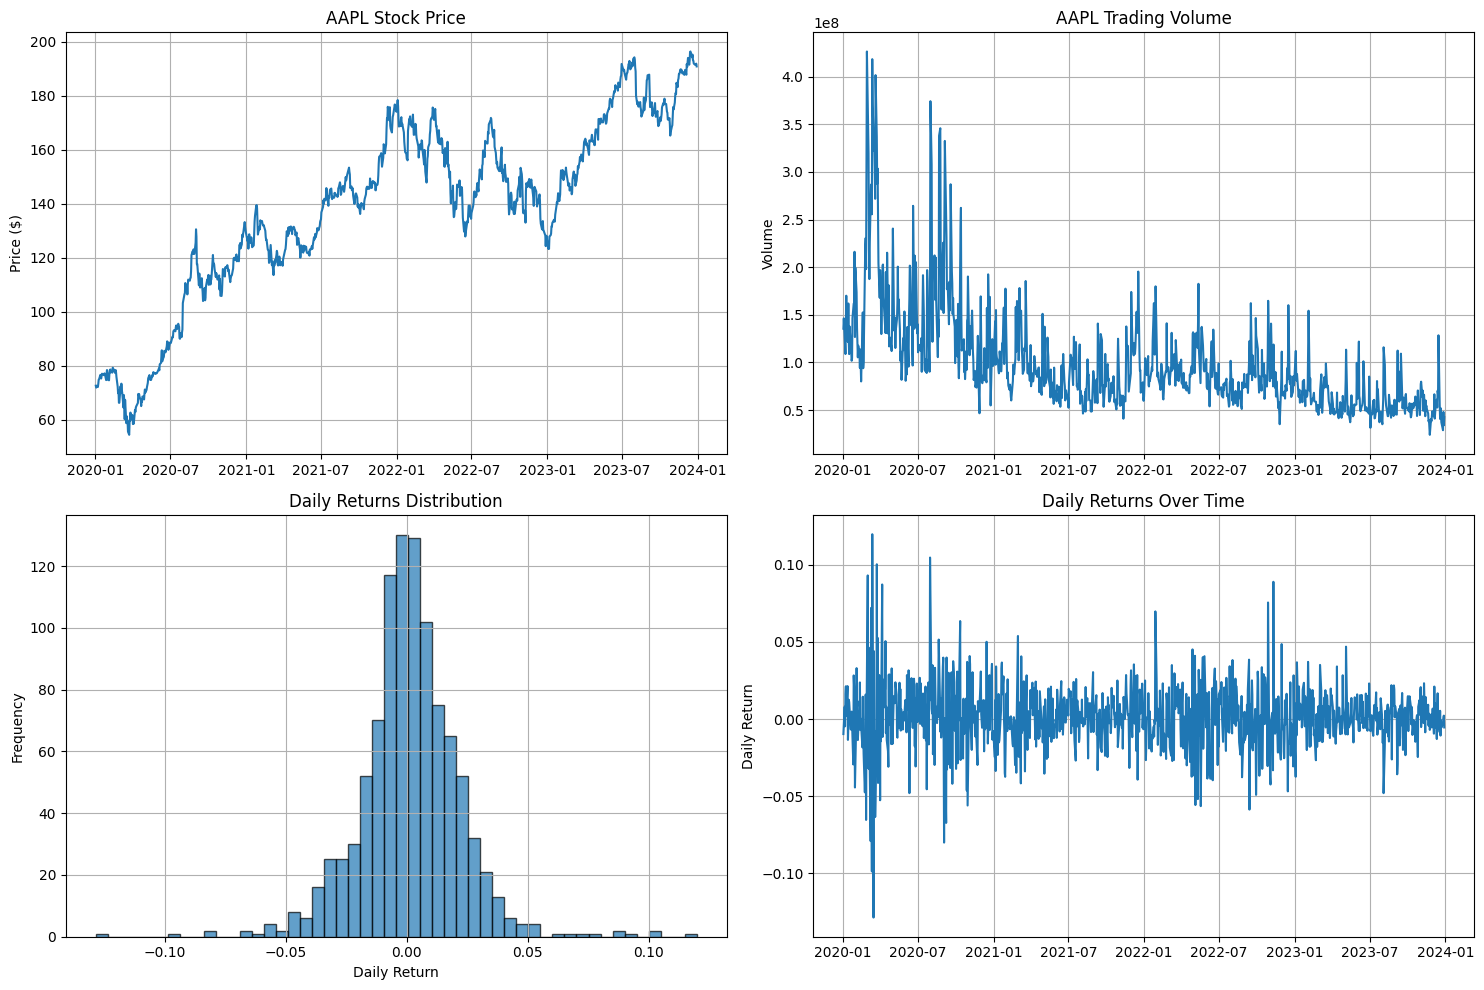

In [12]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price chart
axes[0, 0].plot(data.index, data['Close'])
axes[0, 0].set_title(f'{ticker} Stock Price')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True)

# Volume chart
axes[0, 1].plot(data.index, data['Volume'])
axes[0, 1].set_title(f'{ticker} Trading Volume')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].grid(True)

# Daily returns histogram
axes[1, 0].hist(data['Daily_Return'].dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Daily Returns Distribution')
axes[1, 0].set_xlabel('Daily Return')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True)

# Returns over time
axes[1, 1].plot(data.index, data['Daily_Return'])
axes[1, 1].set_title('Daily Returns Over Time')
axes[1, 1].set_ylabel('Daily Return')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [15]:
# Prepare data for machine learning
# Create features (lagged returns)
data['Return_lag1'] = data['Daily_Return'].shift(1)
data['Return_lag2'] = data['Daily_Return'].shift(2)
data['Return_lag3'] = data['Daily_Return'].shift(3)

# Drop rows with NaN values
ml_data = data[['Close', 'Return_lag1', 'Return_lag2', 'Return_lag3']].dropna()

# Create target variable (next day's return)
ml_data['Target'] = ml_data['Close'].shift(-1) / ml_data['Close'] - 1
ml_data = ml_data.dropna()

print(f"ML dataset shape: {ml_data.shape}")
print(f"Features: {ml_data.columns.tolist()[:-1]}")
print(f"Target: {ml_data.columns.tolist()[-1]}")


ml_data: Ticker            AAPL
Date                  
2020-01-08   73.224411
2020-01-09   74.779755
2020-01-10   74.948845
2020-01-13   76.550026
2020-01-14   75.516365
...                ...
2023-12-22  191.974686
2023-12-26  191.429291
2023-12-27  191.528458
2023-12-28  191.954849
2023-12-29  190.913666

[1002 rows x 1 columns]
ML dataset shape: (1001, 5)
Features: [('Close', 'AAPL'), ('Return_lag1', ''), ('Return_lag2', ''), ('Return_lag3', '')]
Target: ('Target', '')


In [16]:
# Train-test split and model training
X = ml_data[['Return_lag1', 'Return_lag2', 'Return_lag3']]
y = ml_data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"Mean Squared Error: {mse:.6f}")
print(f"R² Score: {r2:.4f}")
print(f"Model coefficients: {model.coef_}")
print(f"Model intercept: {model.intercept_:.6f}")


Model Performance:
Mean Squared Error: 0.000468
R² Score: -0.0307
Model coefficients: [0.04408673 0.02664782 0.00146958]
Model intercept: 0.000585


In [21]:
# Test PyTorch functionality
print("PyTorch Test:")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Create tensors
x = torch.tensor([1.0, 2.0, 3.0, 4.0]).to(device)
y = torch.tensor([2.0, 4.0, 6.0, 8.0]).to(device)

# Simple operations
z = x + y
print(f"x: {x}")
print(f"y: {y}")
print(f"x + y: {z}")

# Matrix multiplication
A = torch.randn(3, 4)
B = torch.randn(4, 2)
C = torch.mm(A, B)
print(f"Matrix A shape: {A.shape}")
print(f"Matrix B shape: {B.shape}")
print(f"Matrix C (A @ B) shape: {C.shape}")

print("\nPyTorch is working correctly! ✅")


PyTorch Test:
PyTorch version: 2.8.0
CUDA available: False
MPS available: True
x: tensor([1., 2., 3., 4.], device='mps:0')
y: tensor([2., 4., 6., 8.], device='mps:0')
x + y: tensor([ 3.,  6.,  9., 12.], device='mps:0')
Matrix A shape: torch.Size([3, 4])
Matrix B shape: torch.Size([4, 2])
Matrix C (A @ B) shape: torch.Size([3, 2])

PyTorch is working correctly! ✅
